# CAM을 만들고 평가해보자

* CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 Softmax layer가 붙는 형태로 구성되어야 한다는 제약이 있으나, Grad-CAM은 이러한 제약이 없습니다.
* CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고 이모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출합니다.
* CAM은 클래스에 대한 활성화 정도를 나타낸 지도입니다. 기본적으로 이 모델은 Classification을 수행하는 모델이고 최종 목표는 이미지 내에서 클래스가 활성화된 위칠을 확인하고 이를 정답과 비교하는 것이므로 위치정보가 기록된 데이터가 함께 있어야 합니다. 

* stanford_dogs 데이터셋을 사용합니다. 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋이고, 라벨이 위치 정보인 바운딩박스 정보를 포함하고 있습니다. 

## 라이브러리 버전 확인하기
---

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CAM, Grad-CAM 용 모델 준비하기

### 데이터셋 다운로드
* stanford_dogs 데이터셋은 12,000장의 학습용 데이터셋과 8580장의 평가용 데이터셋으로 구성되어있습니다. 

In [4]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


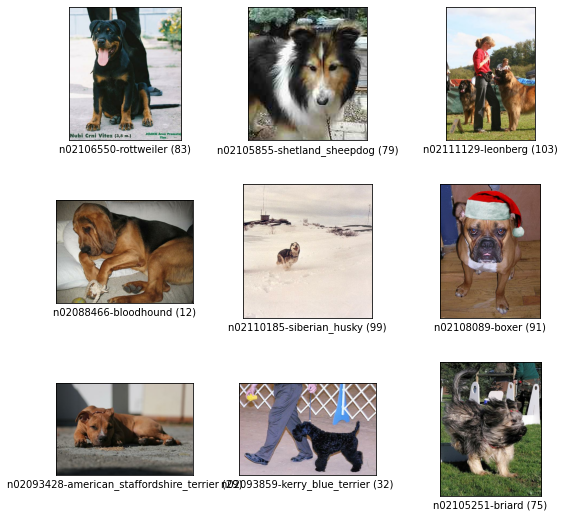

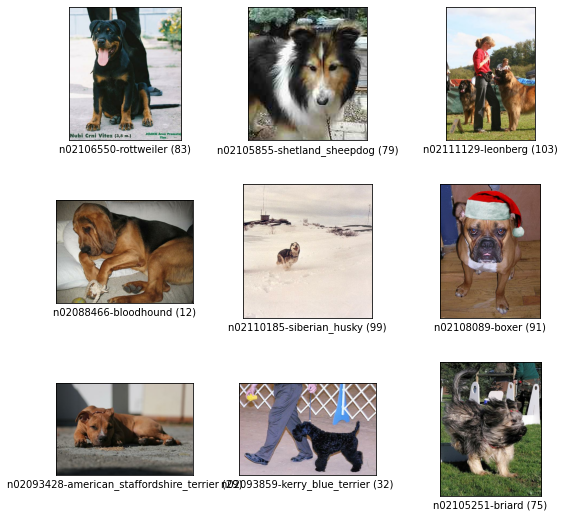

In [5]:
# 각 이미지 클래스와 그 인덱스를 확인합니다.
tfds.show_examples(ds_train, ds_info)

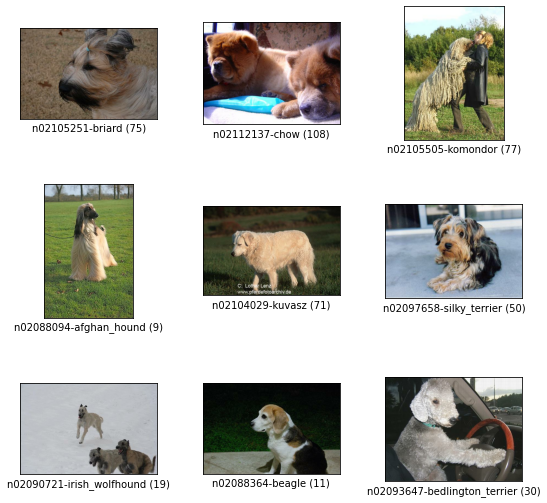

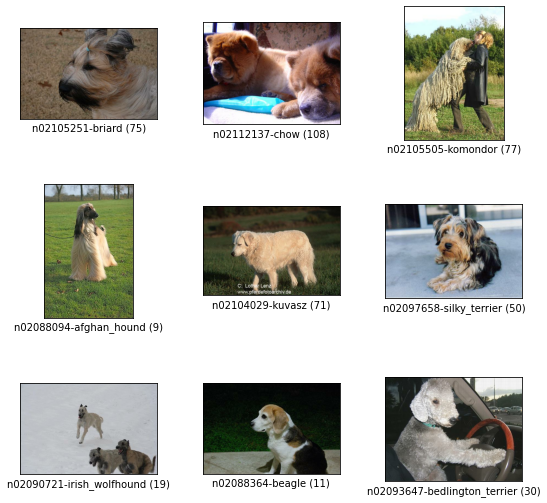

In [6]:
# 테스트데이터셋도 클래스와 인덱스를 확인합니다.
tfds.show_examples(ds_test, ds_info)

### (2) 물체의 위치정보

In [7]:
# 데이터셋의 메타정보인 df_info를 조회해 features가 어떻게 구성되어있는지 확인
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

이 데이터셋에서 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [ymin, xmin, ymax, xmax]를 의미하게 됩니다.

### (3) CAM을 위한 모델 만들기
* 미리 ImageNet 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만듭니다. 


In [8]:
# 구현
num_classes = ds_info.features['label'].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top=False, # Imagenet 분류기 fully connected layer 제거
                                                  weights='imagenet',
                                                  input_shape=(224,224,3),
                                                  pooling='avg') # GAP 적용
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


* CAM 모델은 fully connected layer 대신에 GAP를 사용해주어야 합니다. ResNet50의 매개변수 pooling 에 'avg'를 매개변수로 전달함으로서 쉽게 GAP 연산을 붙일 수 있습니다.

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

* CAM은 feature map을 사용해 만드는데, 위 레이어중 conv5_block3_out의 output이 featuermap이 됩니다.
* 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행합니다. 

### (4) CAM 모델 학습하기
* normalizing, resizing

In [12]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [13]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치 모양 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [14]:
# 모델을 컴파일하고 학습시킵니다.
cam_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])

In [15]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
                                  validation_steps=int(ds_info.splits['test'].num_examples/16),
                                  epochs=10,
                                  validation_data=ds_val_norm,
                                  verbose=1,
                                  use_multiprocessing=True)

Epoch 1/10
750/750 [==============================] - 360s 434ms/step - loss: 2.2641 - accuracy: 0.4366 - val_loss: 2.9648 - val_accuracy: 0.2750
Epoch 2/10
750/750 [==============================] - 331s 441ms/step - loss: 0.6593 - accuracy: 0.8250 - val_loss: 1.2406 - val_accuracy: 0.6391
Epoch 3/10
750/750 [==============================] - 330s 441ms/step - loss: 0.1793 - accuracy: 0.9713 - val_loss: 1.1174 - val_accuracy: 0.6841
Epoch 4/10
750/750 [==============================] - 277s 369ms/step - loss: 0.0596 - accuracy: 0.9963 - val_loss: 1.0135 - val_accuracy: 0.7139
Epoch 5/10
750/750 [==============================] - 358s 477ms/step - loss: 0.0331 - accuracy: 0.9983 - val_loss: 0.9783 - val_accuracy: 0.7255
Epoch 6/10
750/750 [==============================] - 309s 411ms/step - loss: 0.0220 - accuracy: 0.9989 - val_loss: 1.0084 - val_accuracy: 0.7208
Epoch 7/10
750/750 [==============================] - 330s 440ms/step - loss: 0.0171 - accuracy: 0.9994 - val_loss: 0.9858 -

In [16]:
# 학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


CAM 생성작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one()함수로 데이터셋에서 한장씩 뽑을 수 있도록 합니다.

In [22]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


100


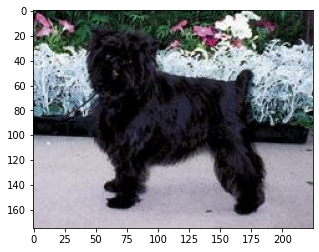

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [87]:

import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


## CAM 구현하기
---

1. CAM을 직접 구현해봅니다. 
* CAM을 생성하기 위해서는 (1) 특성맵, (2)클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3) 원하는 클래스의 출력값이 필요합니다.
* 이미지 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야합니다. 이를 고려하여 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야합니다.

* generate_cam()을 구현하기 위히 아래에는 conv_outputs 와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward 를 거친 후 CAM을 계산하도록 구현하고 마지막으로 resize해줍니다. 

In [88]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


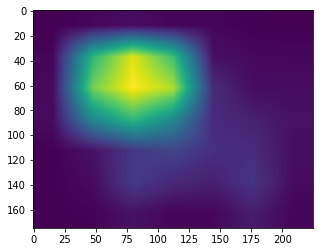

In [89]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [90]:
# CAM 이미지를 원본 이미지와 합쳐봅니다.
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

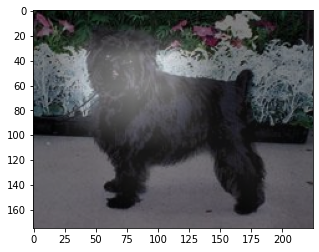

In [91]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

* 생성된 CAM이 주로 얼굴과 몸통 부분을 강조하고 있는데, 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있는 것을 볼 수 있습니다. 

## Grad-CAM 구현하기
---
적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 모델은 cam_model을 그대로 사용합니다. 
* grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한  예측값 사이의 그래디언트를 구하고, 여기서 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weight)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.
* CAM 함수오 ㅏ달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer 의 이름을 받고 이를 활용해야 합니다.
* generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다. 

In [92]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


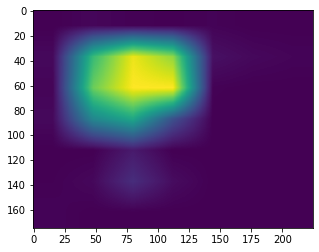

In [93]:
# 여러개의 CAM 이미지를 뽑아서 확인해봅니다. 
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

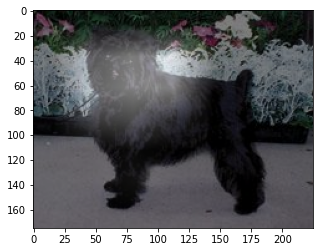

In [95]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()
     

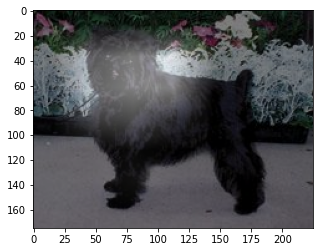

In [97]:

grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(grad_blended_image)
plt.show()

## 바운딩 박스 구현하기
---
CAM에서 물체의 위치를 찾는 detection 을 해봅니다. 
* generate_cam()을 활용해서 CAM 이미지를 뽑습니다. get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스를 없앱니다.
* 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect라는 회전된 바운딩 박스를 얻을 수 있습니다.
* boxPoints()로 이를 꼭지점으로 바꾸어줍니다.

In [98]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect



In [99]:
rect = get_bbox(cam_image)
rect

array([[ 11, 166],
       [ 18,   9],
       [207,  18],
       [200, 175]])

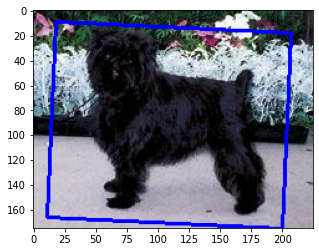

In [100]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

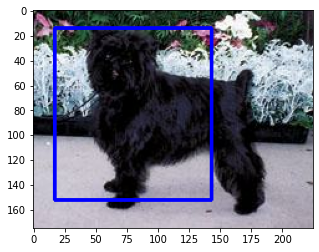

In [101]:
grad_cam_rect = get_bbox(grad_cam_image)
grad_cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [grad_cam_rect], 0, (0, 0, 255),2)
plt.imshow(grad_cam_bbox_image)

## IoU 구하기
---

### Intersection Over Union
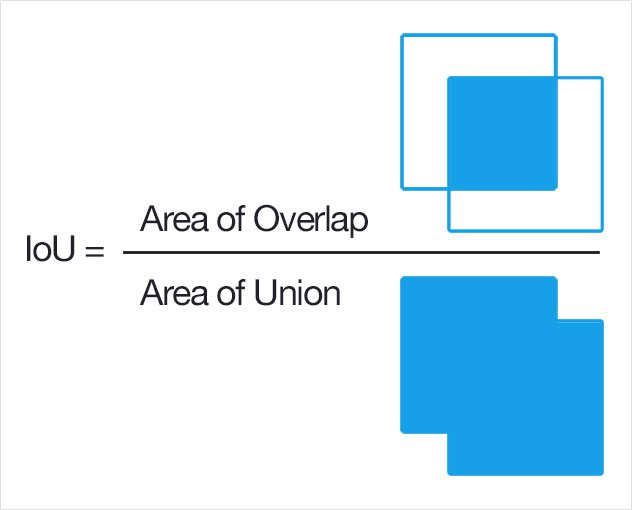

IoU는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union으로 나누어준 값입니다. 이를 통해 찾고자 한 물체의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있습니다. 따라서 모델이 영역을 찾았는지 비교하는 좋은 지표가 됩니다. 


In [102]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox



In [103]:
# 위에서 구한 rect를 minmax bbox 형태로 치환합니다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.05142857142857143, 0.04888888888888889, 1.0, 0.92]

In [104]:
# ground truth bbox를 확인합니다. 
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [105]:
# CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌는지 IoU를 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou



In [106]:
get_iou(pred_bbox, item['objects']['bbox'][0])



0.710105747882142

In [107]:
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])
get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

0.565573753102003

* CAM 으로 얻은 IoU : 0.7102
* Grad-CAM 으로 얻은 IoU : 0.5656

## 회고
---
* CAM으로 얻은 feature map 이 Grad-CAM으로 얻은 feature map 보다 IoU 값이 높았습니다. 그리고 bounding box 만 비교해봐도 CAM은 강아지 전체를 포함하고 있었지만, Grad-CAM은 강아지 뒷다리 부분이 인식이 안된 것을 볼 수 있었습니다. 이번 실습에서는 CAM의 성능이 Grad-CAM 보다 뛰어났습니다.
* 물체를 인식할때 사람의 시각으로는 명확하게 분류할 수 있지만, 인공지능이 보는 feature map을 보니 이